# Study of Stock Portfolio

In [2]:
# activates the matplotlib to be displayed inline
%matplotlib inline 

import os
import random 
import pandas_datareader.data as web
import pandas as pd
import datetime
import numpy as np
from ipywidgets import interact, fixed, IntSlider

import matplotlib.pyplot as plt
from numpy.linalg import cholesky
import seaborn as sns
import quandl # import quandl package
quandl.ApiConfig.api_key = "FX-yxABrQh8R4VCJu8_q" # register at quandl.com and get the API key to feed data
mydata = quandl.get("FRED/GDP")

from dotenv import load_dotenv
load_dotenv()
# magics for import statements
# %load_ext dotenv 
# %dotenv

# cache data for this period
all_data_start, all_data_end = "2016-01-01", "2020-07-01"

# by default work with data in this period
default_start, default_end = "2017-01-01", "2019-07-01"


C:\Users\peter\AppData\Roaming\Python\Python37\site-packages\pandas_datareader\compat\__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


## Get stock data

In [4]:
# pandas datareader
aapl = web.DataReader("AAPL.US","quandl","2015-01-01", "2016-01-01", api_key = "FX-yxABrQh8R4VCJu8_q")
aapl.head()

Open    High       Low   Close      Volume  ExDividend  \
Date                                                                   
2015-12-31  107.01  107.03  104.8200  105.26  40912316.0         0.0   
2015-12-30  108.58  108.70  107.1800  107.32  25213777.0         0.0   
2015-12-29  106.96  109.43  106.8600  108.74  30931243.0         0.0   
2015-12-28  107.59  107.69  106.1807  106.82  26704210.0         0.0   
2015-12-24  109.00  109.00  107.9500  108.03  13596680.0         0.0   

            SplitRatio     AdjOpen     AdjHigh      AdjLow    AdjClose  \
Date                                                                     
2015-12-31         1.0  103.387570  103.406893  101.271705  101.696810   
2015-12-30         1.0  104.904424  105.020361  103.551815  103.687076   
2015-12-29         1.0  103.339263  105.725650  103.242648  105.059007   
2015-12-28         1.0  103.947936  104.044551  102.586343  103.204002   
2015-12-24         1.0  105.310206  105.310206  104.295750  104.373042   

             AdjVolume  
Date                    
2015-12-31  40912316.0  
2015-12-30  25213777.0  
2015-12-29  30931243.0  
2015-12-28  26704210.0  
2015-12-24  13596680.0

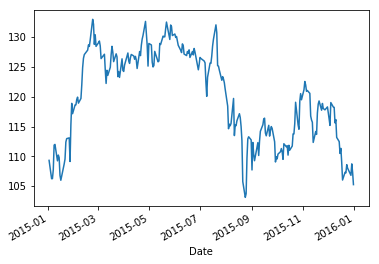

In [5]:
aapl.Close.plot()

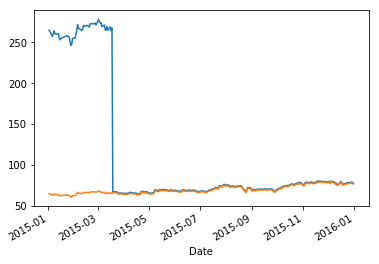

In [6]:
visa = web.DataReader("V.US","quandl","2015-01-01", "2016-01-01", api_key = "FX-yxABrQh8R4VCJu8_q")
visa.Close.plot()
# to adjust for the stock split
visa.AdjClose.plot()

## Utility: get adjusted close, cache recent years

In [82]:
cached_data = {}
#def stock_hist (symbol, start=None, end=None): 
#    """Convenience function to get cached data"""
#    start = start if start else default_start
#    end = end if end else default_end
#    if not symbol in cached_data:
#        cached_data[symbol] = web.DataReader(symbol + ".US", "quandl", all_data_start, all_data_end, api_key = "FX-yxABrQh8R4VCJu8_q")
#        print(f"Loaded {symbol} num values = {len(cached_data[symbol])}")
#    return cached_data[symbol][start:end]
def stock_hist (symbol, start=None, end=None):
    start = start if start else default_start
    end = end if end else default_end
    cached_data[symbol] = web.DataReader(symbol + ".US", "quandl", start, end , api_key = "FX-yxABrQh8R4VCJu8_q")['AdjClose']
    return cached_data[symbol]

In [83]:
start_dt = "2016-01-01"
end_dt = "2016-01-10"
web.DataReader("AAPL.US", "quandl", start = start_dt, end = end_dt , api_key = "FX-yxABrQh8R4VCJu8_q")['AdjClose']
# result for one stock
stock_hist("AAPL").head()


Date
2018-03-27    168.340
2018-03-26    172.770
2018-03-23    164.940
2018-03-22    168.845
2018-03-21    171.270
Name: AdjClose, dtype: float64

## Look at a basket of stocks

AAPL      FB    GOOG
Date                                  
2017-01-03  114.715378  116.86  786.14
2017-01-04  114.586983  118.69  786.90
2017-01-05  115.169696  120.67  794.02
2017-01-06  116.453639  123.41  806.15
2017-01-09  117.520300  124.90  806.65

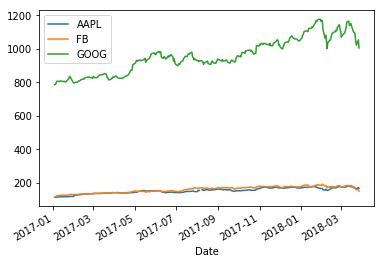

In [84]:
tickers_list = ['AAPL','FB','GOOG']
N = len(tickers_list)
historical = pd.concat((stock_hist(symbol) for symbol in tickers_list), axis = 1, keys = tickers_list)
_=historical.plot() # underscore can be used if don't want to assign the value to anything specific
historical.head()

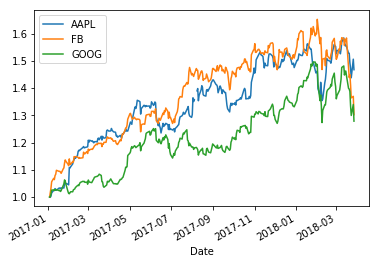

In [85]:
# relative change in prices, price at t divided by the first price row
returns_na = (historical/historical.iloc[0]) #.fillna(method='backfill')
returns = (historical/historical.iloc[0]).fillna(method='backfill') 
_=returns_na.plot()

## Create an equally weighted portfolio

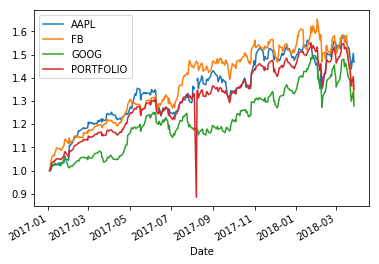

In [86]:
# the glitch is caused by missing values, can be avoided by including the fillna method in the previous step
returns_na['PORTFOLIO'] = returns_na.iloc[:,0:N].sum(axis=1) / N
# iloc below: it can be omitted. It slices all rows (as defined by the row index in iloc ":"), and 0:N columns, which is basically all columns
# axis = 1 means sum along the columns, N was defined above as the length of ticker list
returns['PORTFOLIO'] = returns.iloc[:,0:N].sum(axis=1) / N
returns_na.plot()

In [104]:
symbols = ['AAPL','TSLA','FB','IBM','GOOG']
prices = [stock_hist(symbol) for symbol in symbols]
unit_pos = [p / p[-5] for p in prices]
df = pd.DataFrame(unit_pos)

basket = sum(u for u in unit_pos) / len(unit_pos)
df = pd.DataFrame(basket)
df

AdjClose
Date                
2017-01-03  0.964361
2017-01-04  0.978378
2017-01-05  0.983430
2017-01-06  0.995955
2017-01-09  1.000000
...              ...
2018-03-21  1.301090
2018-03-22  1.267268
2018-03-23  1.234491
2018-03-26  1.264569
2018-03-27  1.209071

[309 rows x 1 columns]

In [107]:
# **active is a **kwargs
# **kwargs allows you to pass keyworded variable length of arguments to a function.
def diversicheck(symbols, start_day=0, **active):
    # The strptime() method creates a datetime object from the given string.
    start = datetime.datetime.strptime(default_start, "%Y-%m-%d") + datetime.timedelta(start_day)
    end = start + datetime.timedelta(days=365)
    # filtered is a kind of check if symbol is valid
    filtered = [symbol for symbol in symbols if active.get(symbol, True)]
    prices = [stock_hist(symbol) for symbol in filtered]
    unit_pos = [p / p[-1-start_day] for p in prices]
    basket = sum(u for u in unit_pos) / len(unit_pos)
    for p in unit_pos:
        p.plot(color='b', alpha=0.3)
    basket.plot(figsize=(20,10))
    print(f"Basket from {start} to {end}")

In [110]:
# Notes: 
# To use interact, you need to define a function that you want to explore. Hence diversicheck is created in the step before.
# fixed() is used within interact which fixes arguments to specific non-modifiable values.

prf_stocks = ['AAPL','TSLA','FB','IBM','GOOG']
active = dict(zip(prf_stocks,[True]*len(prf_stocks)))
_= interact(diversicheck, 
    symbols= fixed(prf_stocks),
    start_day = IntSlider(min=0,max=365, step=1,
                    description='Start date:',
                    disabled=False,
                    continuous_update=True,
                    orientation='horizontal',
                    readout=True,
                    readout_format='d'))

interactive(children=(IntSlider(value=0, description='Start date:', disabled=True, max=365), Output()), _dom_c…

## Simulate forwards

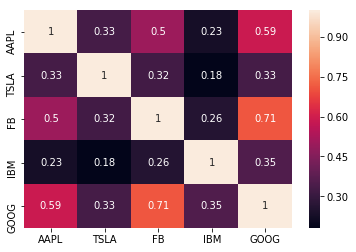

In [96]:
prf_prices = pd.concat((stock_hist(symbol) for symbol in prf_stocks), axis = 1, keys = prf_stocks)
prf_returns = (prf_prices.pct_change() + 1)[1:]
log_returns = np.log(prf_returns)
corr = log_returns.corr()
sns.heatmap(corr, annot=True)

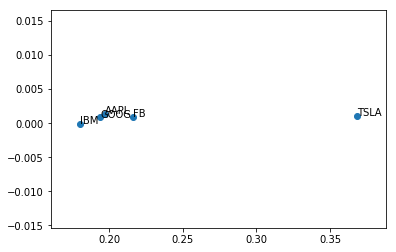

In [150]:
vols = log_returns.std() * np.sqrt(252)
avg_returns = (prf_returns-1).mean()
fig, ax = plt.subplots()
ax.scatter(vols, avg_returns)
for i, txt in enumerate(prf_stocks):
    ax.annotate(txt, (vols[i],avg_returns[i]))

## Bootstrap (Monte-carlo simulation)

In [155]:
# k=60 Returns a list with 60 items, ie. 60 samples are taken 1000 times (60,000 samples in total)
simulated = pd.DataFrame([((prf_returns.iloc[random.choices(
    range(len(prf_returns)),k=60)]).mean(axis=1)).cumprod().values
    for x in range(1000)]).T
simulated.head()

0         1         2         3         4         5         6    \
0  0.997867  1.000355  0.990697  1.012745  1.016644  0.999453  1.002164   
1  0.990728  0.999472  0.996317  1.013146  1.009176  0.990454  1.008559   
2  0.998625  1.005919  0.998603  1.023563  1.020703  0.984672  1.005848   
3  0.988047  1.006788  0.996589  0.988548  1.023069  0.983198  1.020532   
4  0.983911  1.004758  0.991705  0.988236  1.023252  0.991244  1.013695   

        7         8         9      ...          990       991       992  \
0  1.006432  1.015448  0.973625    ...     0.998896  0.990504  0.998860   
1  0.977535  0.986429  0.972574    ...     0.994162  0.997976  0.994416   
2  0.967248  0.992786  0.988761    ...     1.004416  0.998121  0.991743   
3  0.966187  0.997979  0.989194    ...     1.004051  0.998398  1.006222   
4  0.938446  0.985372  0.963830    ...     0.999589  0.997259  1.012694   

        993       994       995       996       997       998       999  
0  0.987137  0.999013  1.007104  1.008599  0.996734  0.996362  0.997419  
1  0.996344  0.996379  1.009170  1.007834  0.998593  0.991929  1.005581  
2  0.989668  0.992138  1.013209  1.019668  0.970056  0.973343  1.008205  
3  0.978816  0.986018  1.010236  0.969434  0.966526  0.974274  1.004536  
4  0.969521  0.982094  1.004004  0.963369  0.936178  0.980302  1.027009  

[5 rows x 1000 columns]

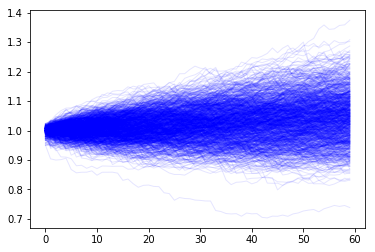

In [157]:
simulated.plot(legend=False, linewidth=1, alpha=0.1, color="blue")

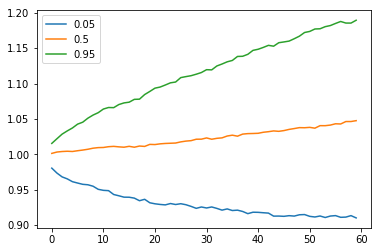

In [161]:
simulated.quantile([0.05,0.5,0.95], axis=1).T.plot()